<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-3--disease-outbreaks/02_geographic_location_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Geographic location analysis

This navigation paradigm perfectly encapsulates the standard data science process. As
data scientists, we are offered raw observations. We algorithmically analyze that data.
Then, we visualize the results to make critical decisions. Thus, data science and location
analysis are linked. That link has only grown stronger through the centuries.

Hedge funds study satellite photos of farmlands to make bets on the
global soybean market. Transport-service providers analyze vast traffic patterns to efficiently
route fleets of cars. Epidemiologists process newspaper data to monitor the
global spread of disease.

In this notebook, we explore a variety of techniques for analyzing and visualizing geographic
locations. We begin with the simple task of calculating the distance between
two geographic points.

##Setup

In [ ]:
!pip -q install cartopy

In [ ]:
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
from scipy import stats
from math import cos, sin, asin
from math import pi

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from scipy.spatial.distance import euclidean
from sklearn.datasets import make_circles

import cartopy
import seaborn as sns
import matplotlib.pyplot as plt

##The great-circle distance

We can compute the great-circle distance given a sphere and two points on that
sphere. 

Any point on the sphere’s surface can be represented using spherical coordinates
x and y, where x and y measure the angles of the point relative to the x-axis and y-axis.

In [ ]:
# Defining a great-circle distance function
def great_circle_distance(x1, y1, x2, y2):
  # Computes the angular difference between the two pairs of spherical coordinates
  delta_x, delta_y = x2 - x1, y2 - y1
  haversin = sin(delta_x / 2) ** 2 + np.product([cos(x1), cos(x2), sin(delta_y / 2) ** 2])
  return 2 * asin(haversin ** .5)

Let’s calculate the greatcircle
distance between two points that lie 180 degrees apart relative to both the x-axis
and the y-axis.

In [ ]:
# Computing the great-circle distance
distance = great_circle_distance(0, 0, 0, pi)
print(f"The distance equals {distance} units.")

The distance equals 3.141592653589793 units.


That value is the longest possible distance we can travel between two spherical
points. 

This is akin to traveling between the North and South Poles of any planet.

Let’s begin by recording the known coordinates of each pole.

In [ ]:
# Defining the coordinates of Earth’s poles
latitude_north, longitude_north = (90.0, 0)
latitude_south, longitude_south = (-90.0, 0)

In [ ]:
# Computing the great-circle distance between poles
to_radians = np.radians([latitude_north, longitude_north, latitude_south, longitude_south])
distance = great_circle_distance(*to_radians.tolist())
print(f"The unit-circle distance between poles equals {distance} units.")

The unit-circle distance between poles equals 3.141592653589793 units.


Now, let’s measure the
distance between two poles here on Earth. 

The radius of Earth is not 1 hypothetical
unit but rather 3956 actual miles, so we must multiply distance by 3956 to obtain a
terrestrial measurement.

In [ ]:
# Computing the travel distance between Earth’s poles
earth_distance = 3956 * distance
print(f"The distance between poles equals {earth_distance} miles.")

The distance between poles equals 12428.14053760122 miles.


In [ ]:
# Defining a travel distance function
def travel_distance(lat1, lon1, lat2, lon2):
  to_radians = np.radians([lat1, lon1, lat2, lon2])
  return 3956 * great_circle_distance(*to_radians.tolist())

assert travel_distance(90, 0, -90, 0) == earth_distance

As discussed, we can pass such metrics into
the DBSCAN clustering algorithm, so we can use `travel_distance` to cluster locations based on their spatial distributions. 

Then we can visually validate the clusters by
plotting the locations on a map. This map plot can be executed using the external `Cartopy` visualization library.

##Plotting maps using Cartopy

The K-means algorithm assumes that inputted data points swirl around K different centers.
Each central coordinate is like a hidden bull’s-eye surrounded by scattered data points. 

The purpose of the algorithm is to uncover these hidden central coordinates.

In [ ]:
# K-means clustering using scikit-learn
cluster_model = KMeans(n_clusters=2)
assigned_bulls_eyes = cluster_model.fit_predict(darts)

print(f"Bull's-eye assignments:")
print(assigned_bulls_eyes)

Bull's-eye assignments:
[0 0 0 ... 1 1 1]


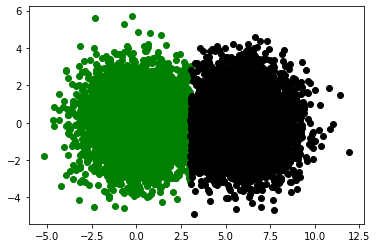

In [ ]:
# Plotting K-means cluster assignments
for bs_index in range(len(bulls_eyes)):
  # Selects the darts most proximate to assigned_bulls_eyes[bs_index]
  selected_darts = [darts[i] for i in range(len(darts)) if bs_index == assigned_bulls_eyes[i]]
  # Separates the x and y coordinates of each dart by transposing an array of selected darts.
  x_coordinates, y_coordinates = np.array(selected_darts).T
  plt.scatter(x_coordinates, y_coordinates, color=["g", "k"][bs_index])
plt.show()

Our clustering model has located the centroids in the data. 

Now we can reuse these
centroids to analyze new data points that the model has not seen before.

In [ ]:
# Using cluster_model to cluster new data
def cluster_data(new_darts):
  new_bulls_eye_assignments = cluster_model.predict(new_darts)
  for i, dart in enumerate(new_darts):
    bulls_eye_index = new_bulls_eye_assignments[i]
    print(f"Dart at {dart} is closest to bull's-eye {bulls_eye_index}")

In [ ]:
new_darts = [[500, 500], [-500, -500]]
cluster_data(new_darts)

Dart at [500, 500] is closest to bull's-eye 1
Dart at [-500, -500] is closest to bull's-eye 0


In [ ]:
new_darts = [[0, 1], [6, 1]]
cluster_data(new_darts)

Dart at [0, 1] is closest to bull's-eye 0
Dart at [6, 1] is closest to bull's-eye 1


In [ ]:
new_darts = [[0.5, 1.5], [6.5, 1.5]]
cluster_data(new_darts)

Dart at [0.5, 1.5] is closest to bull's-eye 0
Dart at [6.5, 1.5] is closest to bull's-eye 1


In [ ]:
new_darts = [[8.5, 3.5], [-3.5, 2.5]]
cluster_data(new_darts)

Dart at [8.5, 3.5] is closest to bull's-eye 1
Dart at [-3.5, 2.5] is closest to bull's-eye 0
